# Imports

In [1]:
import sys
sys.path.append('../..')

In [2]:
# analysis
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import h5py

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

# local
import alignment.alignment_utils as utils
from alignment.AlignCCA import AlignCCA
from processing_utils.poisson_disk_sampling import pitch_subsample_sig_channels
from processing_utils.grid_subsampling import grid_subsample_sig_channels
from processing_utils.spatial_avg_subsampling import spatial_avg_sig_channels, spatial_avg_data

%matplotlib inline

In [3]:
def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# Data Loading

In [4]:
DECODE_PATH = '../../data/results/decoding/'

### Real data

In [5]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [6]:
DATA_PATH = '../../data/'
data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl'
savg_filename = DATA_PATH + 'pt_savg_data_S62.pkl'

In [7]:
all_pt_dict = utils.load_pkl(data_filename)
savg_pt_dict = utils.load_pkl(savg_filename)
pt_names = list(all_pt_dict.keys())

In [8]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print(savg_pt_dict[pt_names[0]].keys())
# print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
dict_keys(['X1', 'y1', 'X2', 'y2', 'X3', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])


In [9]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

## Phoneme label processing functions

In [10]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [11]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [12]:
p_ind = 1

all_pt_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### (trials, time, channels)    
    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

Separate processing for separate spatial averaging data

In [13]:
p_ind = 1
contactSizes = ['8x8', '7x7', '6x6', '5x5', '4x4', '3x3', '2x2', '1x1']

all_savg_traces = {}
all_savg_phon_labels = {}
all_savg_phon_seqs = {}
all_savg_phon_seqs_str = {}
all_savg_artic_labels = {}
all_savg_artic_seqs = {}
all_savg_artic_seqs_str = {}
all_savg_cv_labels = {}
for pt in pt_names:
    savg_trace_dict = {}
    for cs in contactSizes:
        savg_trace_dict[cs] = savg_pt_dict[pt][f'X{p_ind}'][cs]  ### (trials, time, channels)
    
    pt_phon_labels = savg_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = savg_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_savg_traces[pt] = savg_trace_dict
    all_savg_phon_labels[pt] = pt_phon_labels
    all_savg_phon_seqs[pt] = pt_phon_seqs
    all_savg_phon_seqs_str[pt] = pt_phon_seqs_str
    all_savg_artic_labels[pt] = pt_artic_labels
    all_savg_artic_seqs[pt] = pt_artic_seqs
    all_savg_artic_seqs_str[pt] = pt_artic_seqs_str
    all_savg_cv_labels[pt] = pt_cv_labels



In [14]:
n_time = all_pt_traces['S14'].shape[1]
t = np.linspace(-0.5, 0.5 - 1/n_time, n_time)

# Data Visualization

### Utils

In [15]:
px_colors = px.colors.qualitative.Plotly

In [16]:
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [17]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    cbar.outline.set_visible(False)

    sns.despine(left=True, bottom=True)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [19]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [20]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

In [21]:
def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25, t_range=[-0.25, 0.25]):
    min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
    # get data only around speech onset
    t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
    target = target[:, t_inds]
    to_corr = to_corr[:, t_inds]
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    n_cnds = cnd_avg_data[0].shape[0]
    cnd_r = np.zeros(n_cnds)
    for i in range(cnd_avg_data[0].shape[0]):
        target_avg = cnd_avg_data[0][i,:,:min_dim]
        to_corr_avg = cnd_avg_data[1][i,:,:min_dim]

        r_vals = np.zeros(min_dim)
        for j in range(min_dim):
            r_vals[j] = stats.pearsonr(target_avg[:,j], to_corr_avg[:,j])[0]
        cnd_r[i] = np.mean(r_vals)
    return cnd_r

def pt_corr_multi(target, to_corr_list, target_labels, to_corr_labels_list, n_comp=25, t_range=[-0.25, 0.25]):
    cnd_r = []
    for i, to_corr in enumerate(to_corr_list):
        cnd_r.append(pt_corr(target, to_corr, target_labels, to_corr_labels_list[i], n_comp=n_comp, t_range=t_range))
    return cnd_r

In [22]:
def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

## Grid subsampling - all patients

In [24]:
# pt_list = ['S14', 'S22', 'S23', 'S26', 'S33', 'S39', 'S58', 'S62']
pt_list = paper_pt_dict.keys()

pInd_list = [-1]

grid_list = ['2-4', '3-6', '4-8', '5-10', '6-12', '7-14', '8-16']

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        for grid in grid_list:
            g_dims = grid.split('-')
            g_dims_int = [int(g) for g in g_dims]

            # since different grid subsamplings will have different numbers of iterations, create nan array to hold acc values
            # and then nans will be dropped in the dataframe later
            p_tar = np.empty((2, 300))
            p_tar[:] = np.nan

            pt_spf_accs = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'ptSpecific/{pt}/grid_subsampling/{pt}_{p_str}_gridSubsamp{grid}_ptSpecific_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[0,:len(pt_spf_accs)] = pt_spf_accs

            cca_accs = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'pooled/S62_added/{pt}/grid_subsampling/cca/{pt}_{p_str}_gridSubsamp{grid}_pooled_ccaAligned_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[1,:len(cca_accs)] = cca_accs
            
            decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific', 'Aligned cross-patient'])

            wide_dfs.append(decode_df)
            decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='Decoding Accuracy')
            decode_df['Patient'] = paper_pt_dict[pt]
            decode_df['Phoneme Index'] = p_str
            decode_df['Grid Size'] = grid.replace('-', 'x')
            decode_df['Grid X'] = g_dims_int[0]
            decode_df['Grid Y'] = g_dims_int[1]
            cols = decode_df.columns.tolist()
            cols = cols[-4:] + cols[:-4]
            decode_df = decode_df[cols]
            long_dfs.append(decode_df)

grid_decode_df_wide = pd.concat(wide_dfs)
grid_decode_df_long = pd.concat(long_dfs)

# drop nan values used for size consistency above
grid_decode_df_long = grid_decode_df_long.dropna()

grid_decode_df_long = grid_decode_df_long.sort_values(by=['Grid X', 'Decoding Context'])

In [25]:
grid_decode_df_long

,Phoneme Index,Grid Size,Grid X,Grid Y,Decoding Context,Decoding Accuracy,Patient
300,pAll,2x4,2,4,Aligned cross-patient,0.118056,S1
301,pAll,2x4,2,4,Aligned cross-patient,0.145833,S1
302,pAll,2x4,2,4,Aligned cross-patient,0.115741,S1
303,pAll,2x4,2,4,Aligned cross-patient,0.111111,S1
304,pAll,2x4,2,4,Aligned cross-patient,0.101852,S1
...,...,...,...,...,...,...,...
30,pAll,8x16,8,16,Patient-specific,0.294007,S8
31,pAll,8x16,8,16,Patient-specific,0.299625,S8
32,pAll,8x16,8,16,Patient-specific,0.277154,S8
33,pAll,8x16,8,16,Patient-specific,0.322097,S8


In [26]:
mean_grid_decode_df = grid_decode_df_long.drop(columns=['Phoneme Index']).groupby(['Patient', 'Grid Size', 'Decoding Context']).mean().reset_index()
mean_grid_decode_df

,Patient,Grid Size,Decoding Context,Grid X,Grid Y,Decoding Accuracy
0,S1,2x4,Aligned cross-patient,2.0,4.0,0.180530
1,S1,2x4,Patient-specific,2.0,4.0,0.201694
2,S1,3x6,Aligned cross-patient,3.0,6.0,0.215488
3,S1,3x6,Patient-specific,3.0,6.0,0.237619
4,S1,4x8,Aligned cross-patient,4.0,8.0,0.260700
...,...,...,...,...,...,...
107,S8,6x12,Patient-specific,6.0,12.0,0.263729
108,S8,7x14,Aligned cross-patient,7.0,14.0,0.308191
109,S8,7x14,Patient-specific,7.0,14.0,0.286656
110,S8,8x16,Aligned cross-patient,8.0,16.0,0.320974


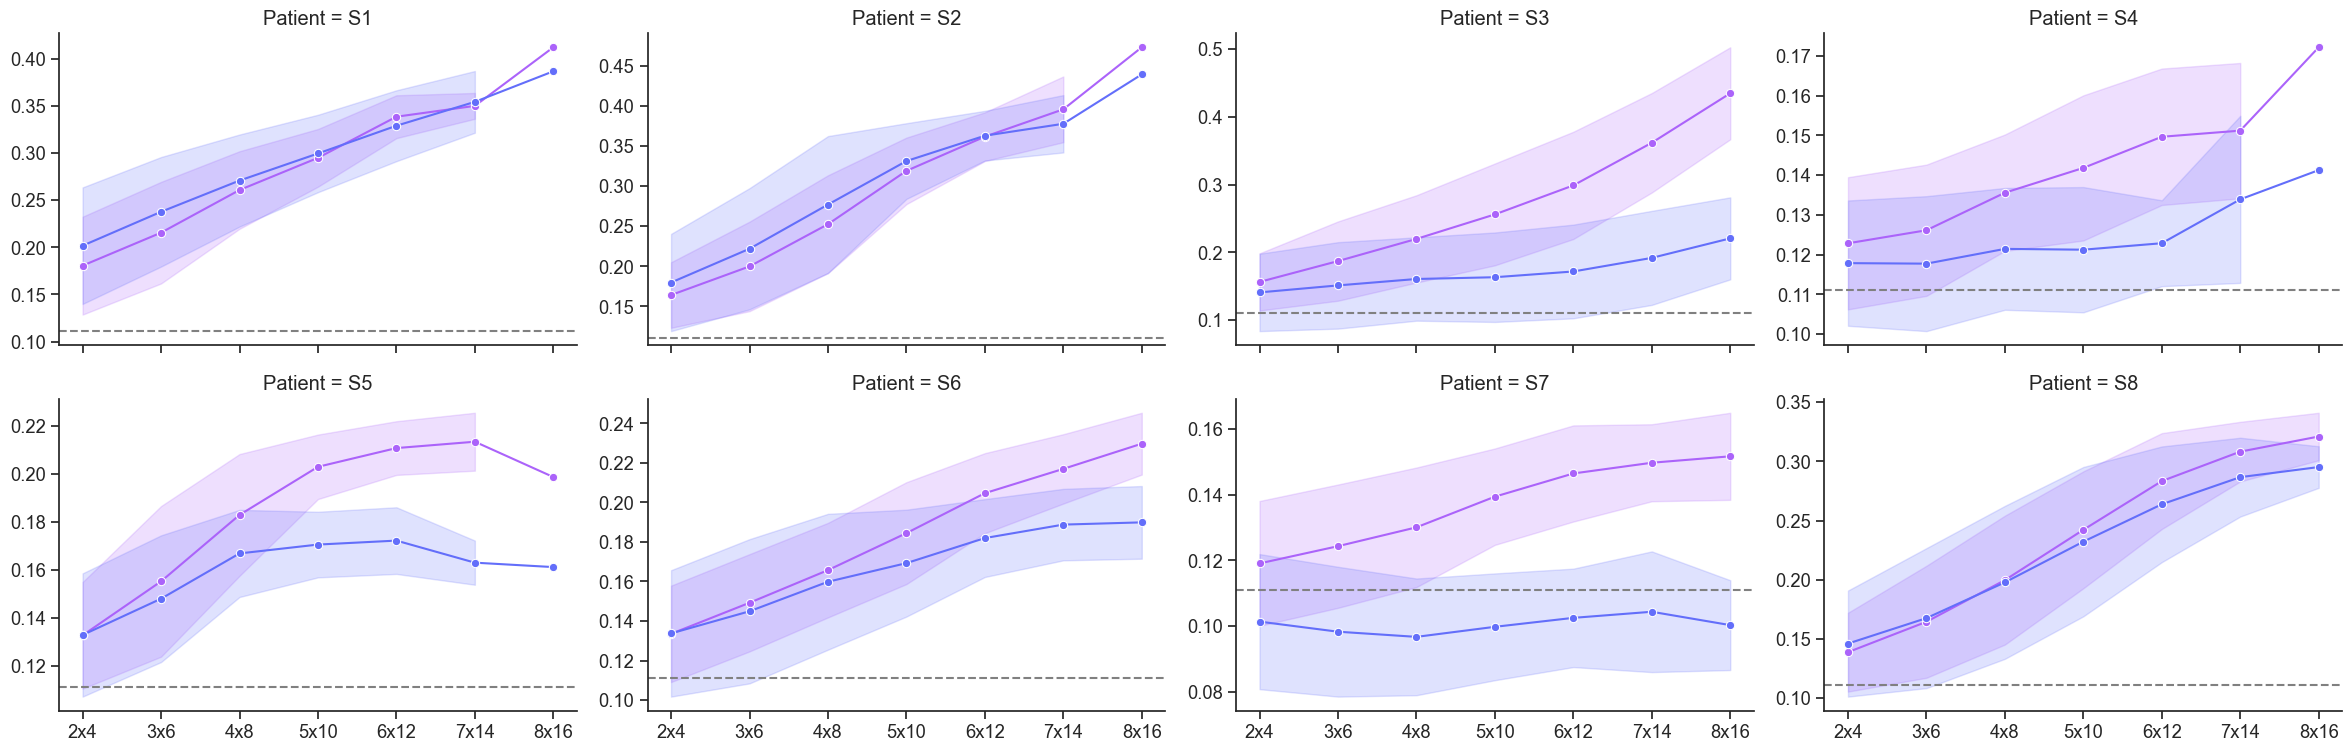

In [ ]:
g = sns.FacetGrid(grid_decode_df_long, col='Patient', col_wrap=4, height=4, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'Grid Size', 'Decoding Accuracy', 'Decoding Context', marker='o', errorbar='sd', palette=[px_colors[3], px_colors[0]])

for i, g_ax in enumerate(g.axes):
    g_ax.set_xlabel('')
    g_ax.set_ylabel('')
    g_ax.axhline(1/9, color='grey', linestyle='--')
    # g_ax.set_ylim(0.05, 0.45)
    # g_ax.legend(loc='upper left')


sns.despine()
plt.show()